# The data pre-process 

``` Python
import numpy as np  # Import the numpy library for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import librosa  # Import librosa for audio processing
import librosa.display  # Import librosa display utilities
import os  # Import os for interacting with the operating system

def extract_audio_features(audio_data, sample_rate):
    """
    Extracts audio features using librosa.

    Parameters:
    audio_data (numpy.ndarray): The audio data.
    sample_rate (int): The sampling rate.

    Returns:
    tuple: Fbank, fundamental frequency, spectral centroid, and spectral contrast.
    """
    # Calculate Mel-spectrogram features (Mel frequency)
    fbank_features = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    
    # Calculate pitch
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sample_rate)
    pitch_indices = np.argmax(magnitudes, axis=0)
    fundamental_frequencies = pitches[pitch_indices, np.arange(pitches.shape[1])]
    
    # Calculate fundamental period, removing invalid values
    fundamental_period = 1 / fundamental_frequencies
    fundamental_period = fundamental_period[np.isfinite(fundamental_period)]  # Remove non-finite values
    fundamental_period = fundamental_period[fundamental_period > 0]  # Keep only positive values

    # Calculate spectral centroid and spectral contrast
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
    
    return fbank_features, fundamental_period, spectral_centroid, spectral_contrast

def visualize_and_save_features(fbank_features, fundamental_period, spectral_centroid, spectral_contrast, output_path):
    """
    Visualizes and saves audio features.

    Parameters:
    fbank_features (numpy.ndarray): Fbank features.
    fundamental_period (numpy.ndarray): Fundamental frequency.
    spectral_centroid (numpy.ndarray): Spectral centroid.
    spectral_contrast (numpy.ndarray): Spectral contrast.
    output_path (str): Path to save the image.
    """
    plt.figure(figsize=(60, 60))
    
    # Histogram of fundamental period
    plt.subplot(3, 1, 1)
    if fundamental_period.size > 0:  # Check if there are valid fundamental periods
        plt.hist(fundamental_period, bins=100, color='blue', alpha=0.7)
    plt.axis('off')  # Remove axis

    # Histogram of spectral centroid
    plt.subplot(3, 1, 2)
    plt.hist(spectral_centroid.flatten(), bins=100, color='green', alpha=0.7)
    plt.axis('off')  # Remove axis

    # Histogram of spectral contrast
    plt.subplot(3, 1, 3)
    plt.hist(spectral_contrast.flatten(), bins=100, color='red', alpha=0.7)
    plt.axis('off')  # Remove axis

    plt.tight_layout()
    plt.savefig(output_path, dpi=50)
    plt.close()

def process_audio_directory(input_directory, output_directory):
    """
    Processes all audio files in a directory and saves their features.

    Parameters:
    input_directory (str): Directory containing audio files.
    output_directory (str): Directory to save feature images.
    """
    os.makedirs(output_directory, exist_ok=True)
    
    for filename in os.listdir(input_directory):
        if filename.endswith('.wav'):
            try:
                file_path = os.path.join(input_directory, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None, mono=True)
                fbank_features, fundamental_period, spectral_centroid, spectral_contrast = extract_audio_features(audio_data, sample_rate)
                
                output_filename = os.path.splitext(filename)[0] + '.jpg'
                output_path = os.path.join(output_directory, output_filename)
                visualize_and_save_features(fbank_features, fundamental_period, spectral_centroid, spectral_contrast, output_path)
                
                print(f"Successfully processed and saved feature image: {output_filename}")
            
            except Exception as e:
                print(f"Error processing {filename}: {e}")

if __name__ == "__main__":
    input_directory = 'wav'
    output_directory = 'wav_features'
    
    process_audio_directory(input_directory, output_directory)

```

## Build the Dataset




In [10]:
import os  # Importing os module for operating system related functionalities  
from torchvision.io import read_image  # Importing read_image function to read image files  
import pandas as pd  # Importing pandas for handling data in DataFrames, useful for reading labels  
from torch.utils.data import Dataset  # Importing Dataset class for creating custom datasets in PyTorch  
import matplotlib.pyplot as plt  # Importing matplotlib for plotting images (not used in the provided code)  
import numpy as np  # Importing numpy for numerical operations (not used in the provided code)  
from torch.utils.data import DataLoader  # Importing DataLoader for batching and shuffling the dataset (not used in the provided code)  
from torchvision import transforms  # Importing transforms to apply preprocessing to images (not used in the provided code)  

# Class definition for a custom image dataset inheriting from PyTorch's Dataset  
class myImageDataset(Dataset):  
    def __init__(self, img_dir, img_label_dir, transform=None):  
        """  
        Initialize the dataset.  
        
        Parameters:  
        img_dir (str): Directory where the images are stored.  
        img_label_dir (str): Path to the CSV file containing image filenames and their corresponding labels.  
        transform (callable, optional): A function/transform to apply to the image.  
        """  
        super().__init__()  # Calling the parent class's initializer  
        self.img_dir = img_dir  # Storing the image directory path  
        self.img_labels = pd.read_csv(img_label_dir)  # Reading the CSV file into a DataFrame.  
        # The DataFrame contains image filenames and their corresponding labels.  
        # Expected format: 0 column for filenames, 1 column for labels  
        self.transform = transform  # Storing the transformation function if provided  

    def __len__(self):  
        """  
        Returns the total number of samples in the dataset.  
        
        Returns:  
        int: Number of samples in the dataset.  
        """  
        return len(self.img_labels)  # Length of the DataFrame determines the number of samples  
    
    def __getitem__(self, index):  
        """  
        Retrieve a sample from the dataset at the given index.  
        
        Parameters:  
        index (int): Index of the sample to retrieve.  
        
        Returns:  
        tuple: (image, label) - A tuple containing the image tensor and its corresponding label.  
        """  
        # Construct the image file path by combining the directory and filename  
        # Example: img_dir = 'D:/curriculum/2022learning/learnning_dataset/data/'   
        # img_labels.iloc[index, 0] = '5.jpg'   
        # Therefore, img_path = 'D:/curriculum/2022learning/learnning_dataset/data/5.jpg'  
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])  # Joining paths for the image file  
        image = read_image(img_path)  # Reading the image file and converting it to a tensor  
        label = self.img_labels.iloc[index, 1]  # Accessing the corresponding label from the DataFrame  

        # If a transform function is specified, apply it to the image tensor  
        if self.transform is not None:  
            image = self.transform(image)  # Perform transformations on the image if provided  
        
        return image, label  # Returning the image tensor and its label as a tuple

In [11]:
# Function to convert a tensor representation of an image into a format suitable for display  
def tensorToimg(img_tensor):  
    """  
    Converts a tensor representing an image to a format for display using matplotlib.  

    Parameters:  
    img_tensor (torch.Tensor): A tensor representing the image, typically in CHW format.  
    """  
    img = img_tensor.numpy()  # Convert the tensor to a NumPy array for manipulation  
    img = np.transpose(img, [1, 2, 0])  # Change the tensor's dimensions from CHW (Channel, Height, Width) to HWC (Height, Width, Channel)  
    plt.imshow(img)  # Display the image using matplotlib's imshow function  

# Define a set of transformations to apply to images during loading  
transform = transforms.Compose([  
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels for consistency  
    transforms.Grayscale(num_output_channels=1)  # Convert images to grayscale, outputting a single channel  
])  

# Dictionary mapping numerical labels to corresponding class names  
label_dic = {0: 'fake', 1: 'true'}  # Class mapping for labels, where 0 corresponds to 'fake' and 1 corresponds to 'true'  

# Paths to the CSV files containing labels for training and test datasets  
label_path = 'index1.csv'  # Path to the CSV file for training labels  
img_root_path = 'train_picture/'  # Directory containing training images  

label_path1 = 'index2.csv'  # Path to the CSV file for testing labels  
img_root_path1 = 'test_picture/'  # Directory containing testing images  

# Instantiate the training dataset using the custom myImageDataset class defined earlier  
dataset_train = myImageDataset(img_root_path, label_path, transform)  
# Instantiate the testing dataset using the custom myImageDataset class  
dataset_test = myImageDataset(img_root_path1, label_path1, transform)

torch.Size([1, 224, 224])
true


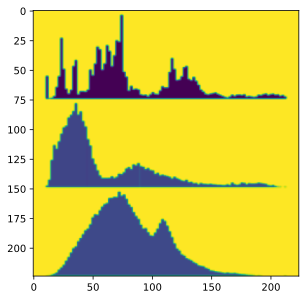

In [12]:
# Testing the built dataset by retrieving a sample from the test dataset  

image, label = dataset_test.__getitem__(10)  # Retrieve the image and label at index 20 from the test dataset  
print(image.shape)  # Output the shape of the image tensor, useful for understanding the dimensions of the image tensor  
print(label_dic[label])  # Use the label dictionary to print the human-readable label corresponding to the numeric label  
tensorToimg(image)  # Call the tensorToimg function to visualize the retrieved image tensor  

torch.Size([1, 224, 224])
fake


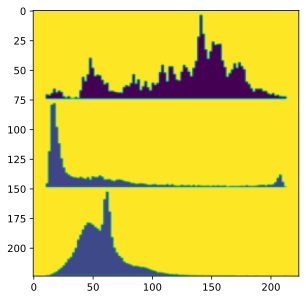

In [13]:
# Testing the built dataset by retrieving a sample from the training dataset 

image, label = dataset_train.__getitem__(10)  # Retrieve the image and label at index 20 from the training dataset  
print(image.shape)  # Output the shape of the image tensor from the training dataset  
print(label_dic[label])  # Print the human-readable label using the label dictionary  
tensorToimg(image)  # Visualize the image tensor from the training dataset using the tensorToimg function 

## Build the net



In [14]:
import torch  
from torch import nn  
from torch.nn import functional as F  
from d2l import torch as d2l  
import pandas as pd  

# This class defines a Residual Block used in deep learning architectures,   
# particularly in ResNet models. A Residual Block allows the model to learn   
# residual mappings instead of direct mappings, helping to address issues   
# like vanishing gradients in deep networks.  

class Residual(nn.Module):  #@save  
    def __init__(self, input_channels, num_channels,  
                 use_1x1conv=False, strides=1):  
        super().__init__()  
        # Initialize two convolutional layers within the residual block.  
        # The first layer transforms the input channels to `num_channels`   
        # using a 3x3 convolution.  
        self.conv1 = nn.Conv2d(input_channels, num_channels,  
                               kernel_size=3, padding=1, stride=strides)  
        # The second layer also uses a 3x3 convolution, maintaining the number   
        # of channels.  
        self.conv2 = nn.Conv2d(num_channels, num_channels,  
                               kernel_size=3, padding=1)  
        
        # The use of a 1x1 convolution layer (conv3) is conditional based on   
        # the `use_1x1conv` parameter. This allows matching   
        # dimensions of the input (X) and the output of the second convolution (Y)  
        # when the shapes differ due to strides or channel changes.  
        if use_1x1conv:  
            self.conv3 = nn.Conv2d(input_channels, num_channels,  
                                   kernel_size=1, stride=strides)  
        else:  
            self.conv3 = None  
            
        # Batch normalization layers are used after each convolution to stabilize  
        # and accelerate the training of the neural network by normalizing the  
        # inputs to each layer.  
        self.bn1 = nn.BatchNorm2d(num_channels)  
        self.bn2 = nn.BatchNorm2d(num_channels)  
    
    # The forward method defines the forward pass for the residual block.  
    def forward(self, X):  
        # Apply the first convolution followed by batch normalization and a ReLU activation.  
        Y = F.relu(self.bn1(self.conv1(X)))  
        
        # Apply the second convolution followed by batch normalization.  
        Y = self.bn2(self.conv2(Y))  
        
        # If a 1x1 convolution is defined, it is applied to the input X to adjust  
        # the dimensions so that it can be added correctly to Y later.  
        if self.conv3:  
            X = self.conv3(X)  
        
        # Perform the residual addition where the original input X is added   
        # to the processed Y, enabling the learning of residual mappings.  
        Y += X  
        
        # Finally, apply ReLU activation to the result of the residual addition   
        # before returning it.  
        return F.relu(Y)

In [15]:
# Building the first two layers of the ResNet architecture  
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  # Convolutional layer  
                   nn.BatchNorm2d(64),  # Batch normalization layer  
                   nn.ReLU(),  # Activation function (ReLU)  
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))  # Max pooling layer  

# Function to construct a ResNet block  
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):  
    """  
    Constructs a ResNet block containing a specified number of residual blocks.  

    Parameters:  
    input_channels (int): Number of input channels for the block.  
    num_channels (int): Number of channels in the residual blocks.  
    num_residuals (int): Number of residual blocks to create within this block.  
    first_block (bool): Flag indicating if this is the first block in the ResNet architecture.  
    
    Returns:  
    list: A list of residual blocks.  
    """  
    blk = []  # Initialize an empty list to hold the blocks  
    for i in range(num_residuals):  # Loop over the number of residual blocks to add  
        if i == 0 and not first_block:  
            # If the current block is the first in the sequence but not the first block of the network,  
            # align the input channels with output channels using a 1x1 convolutional layer  
            # This ensures the dimensions match for the residual connection  
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))  
        else:  
            # For subsequent residual blocks, maintain the same number of channels  
            blk.append(Residual(num_channels, num_channels))  
    return blk  # Return the constructed list of residual blocks  

# Constructing the residual blocks: each module uses two residual blocks  
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))  # First block with 2 residuals  
b3 = nn.Sequential(*resnet_block(64, 128, 2))  # Second block, doubling the number of channels  
b4 = nn.Sequential(*resnet_block(128, 256, 2))  # Third block, further doubling  
b5 = nn.Sequential(*resnet_block(256, 512, 2))  # Fourth block, again doubling  

# Final network definition  
## Just like GoogLeNet, ResNet includes a global average pooling layer and a fully connected layer for output.  
net = nn.Sequential(b1, b2, b3, b4, b5,  
                    nn.AdaptiveAvgPool2d((1,1)),  # Adaptive average pooling to reduce the feature map to 1x1  
                    nn.Flatten(),  # Flatten the output for the fully connected layer
                    nn.Linear(512, 2))  # Fully connected layer to produce final output with 2 classes  

# Observing the network construction and structure  
X = torch.rand(size=(1, 1, 224, 224))  # Create a random input tensor simulating a single grayscale image of size 224x224  
for layer in net:  # Iterate over each layer in the network  
    X = layer(X)  # Pass the input through each layer  
    print(layer.__class__.__name__, 'output shape:\t', X.shape)  # Print the layer type and the output shape

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 2])


## Build the training method

In [16]:
# @save  
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):  
    """  
    Train a neural network and evaluate its performance.  

    Parameters:  
    net (nn.Module): The neural network to be trained.  
    train_iter (DataLoader): DataLoader for the training dataset.  
    test_iter (DataLoader): DataLoader for the testing dataset.  
    num_epochs (int): Number of epochs for training.  
    lr (float): Learning rate for the optimizer.  
    device (torch.device): Device to run the training on (CPU or GPU).  
    """  
    
    # Function to initialize weights for layers  
    def init_weights(m):  
        """  
        Initialize weights for linear and convolutional layers using Xavier uniform distribution.  
        
        Parameters:  
        m (nn.Module): The layer to initialize.  
        """  
        if type(m) == nn.Linear or type(m) == nn.Conv2d:  
            nn.init.xavier_uniform_(m.weight)  # Apply Xavier initialization to weights  

    net.apply(init_weights)  # Apply the weight initialization function to the network  
    print('training on', device)  # Print which device is being used for training  
    net.to(device)  # Move the network to the specified device (CPU or GPU)  
    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  # Define the optimizer (Stochastic Gradient Descent)  
    loss = nn.CrossEntropyLoss()  # Define the loss function (Cross-Entropy Loss for classification)  
    
    # Animator for visualizing training progress  
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],  
                            legend=['train loss', 'train acc', 'test acc'])  
    
    timer, num_batches = d2l.Timer(), len(train_iter)  # Initialize timer and get number of batches in training  
    for epoch in range(num_epochs):  # Loop over the number of epochs  
        # Initialize metrics for training loss, training accuracy, and number of samples  
        metric = d2l.Accumulator(3)  # Accumulator to keep track of metrics  
        net.train()  # Set the network to training mode  
        
        for i, (X, y) in enumerate(train_iter):  # Iterate through the training data  
            timer.start()  # Start the timer for this batch  
            optimizer.zero_grad()  # Reset gradients for the optimizer  
            
            # Move data to the specified device  
            X, y = X.to(device), y.to(device)  

            # Ensure the data types are correct  
            y = y.float()  # Convert labels to float for compatibility  
            X = X.float()  # Convert input data to float  
            
            y_hat = net(X)  # Forward pass: compute predicted outputs  
            
            y = y.long()  # Convert labels back to long type for loss computation  
            
            l = loss(y_hat, y)  # Compute the loss between predicted and actual labels  
            l.backward()  # Backward pass: compute gradients  
            optimizer.step()  # Update weights based on gradients  
            
            with torch.no_grad():  # Disable gradient tracking for metric calculation  
                # Update the metric with the current batch's loss, accuracy, and size  
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])  
            timer.stop()  # Stop the timer for this batch  
            
            # Calculate average training loss and accuracy  
            train_l = metric[0] / metric[2]  # Average loss  
            train_acc = metric[1] / metric[2]  # Average accuracy  
            
            # Update animator with current epoch and metrics  
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:  
                animator.add(epoch + (i + 1) / num_batches,  
                             (train_l, train_acc, None))  # Add training metrics to animator  
        
        # Evaluate the model on the test dataset  
        test_acc = evaluate_accuracy_gpu(net, test_iter)  # Calculate test accuracy  
        animator.add(epoch + 1, (None, None, test_acc))  # Add test accuracy to animator  
    
    # Print final training metrics  
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '  
          f'test acc {test_acc:.3f}')  
    
    # Print the average number of examples processed per second  
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '  
          f'on {str(device)}')

## Build the accuracy calculation method

In [17]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  # @save  
    """  
    Evaluate the accuracy of the model on a given dataset using a GPU if available.  

    Parameters:  
    net (nn.Module): The neural network model to evaluate.  
    data_iter (DataLoader): DataLoader for the dataset to evaluate the model on.  
    device (torch.device, optional): The device (CPU or GPU) to perform the evaluation on.  

    Returns:  
    float: The accuracy of the model on the dataset.  
    """  
    # Check if the provided network is an instance of nn.Module  
    if isinstance(net, nn.Module):  
        net.eval()  # Set the network to evaluation mode (disables dropout, batch normalization updates, etc.)  
        
        # If no specific device is provided, infer the device from the model's parameters  
        if not device:  
            device = next(iter(net.parameters())).device  
            
    # Initialize metric to track the number of correct predictions and the total number of predictions  
    metric = d2l.Accumulator(2)  # (correct predictions, total predictions)  
    
    with torch.no_grad():  # Disable gradient tracking to speed up computations and reduce memory usage  
        for X, y in data_iter:  # Iterate through the data loader  
            if isinstance(X, list):  # Check if input X is a list (needed for BERT fine-tuning)  
                # Move each input tensor in the list to the specified device and convert to float  
                X = [x.to(device) for x in X]  
                X = [x.float() for x in X]  # Ensure all inputs are of type float  
            else:  
                X = X.to(device)  # Move the input tensor to the specified device  
                X = X.float()  # Ensure the input tensor is of type float  

            y = y.to(device).float()  # Move the target tensor to the specified device and convert to float  
            
            # Compute the accuracy of the model's predictions using the network and the true labels  
            metric.add(d2l.accuracy(net(X), y), y.numel())  # Update the metric with correct predictions and total predictions  
        
    # Return the accuracy as the ratio of correct predictions to total predictions  
    return metric[0] / metric[1]  # metric[0]: total correct predictions, metric[1]: total samples

## The training process


loss 0.718, train acc 0.557, test acc 0.567
164.3 examples/sec on cuda:0


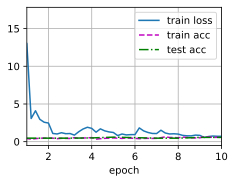

In [18]:
batch_size = 15
train_iter = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
test_iter = DataLoader(dataset_test, batch_size = batch_size, shuffle=True)

lr, num_epochs = 0.2, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


loss 0.749, train acc 0.586, test acc 0.533
180.8 examples/sec on cuda:0


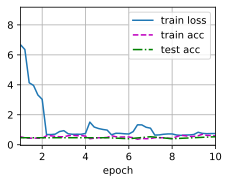

In [19]:
lr, num_epochs = 0.15, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.302, train acc 0.871, test acc 0.467
173.0 examples/sec on cuda:0


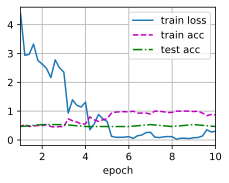

In [20]:
lr, num_epochs = 0.05, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())